In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
df = pd.read_csv(r"E:\projects\nature-sales-forecasting\data\dataDumpDayItemandRateWise.csv")

df['trnDate'] = pd.to_datetime(df['trnDate'], errors='coerce')

daily = df.groupby('trnDate')['quantity'].sum().asfreq('D').fillna(0)
daily[daily == 133673.0] = 3299.4310344



SARIMA + ML Hybrid RMSE: 355.0431, MAE: 274.5888


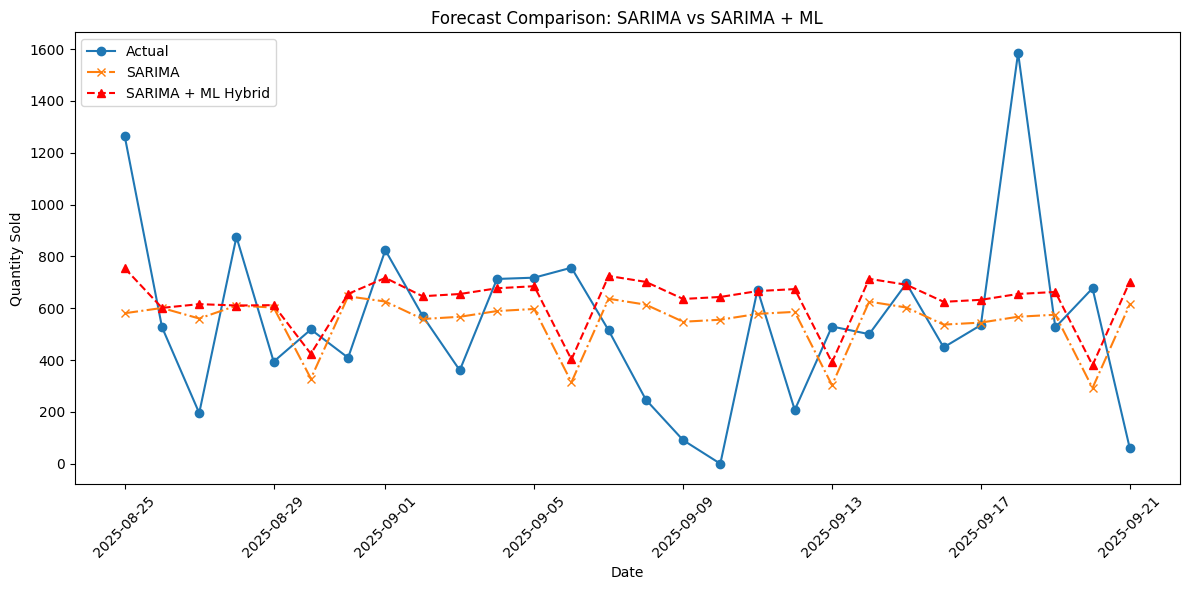

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

train_d = daily[:-28]
test_d = daily[-28:]

# ------------------------
# 2️⃣ Fit SARIMA on training data
# ------------------------
# Adjust (p,d,q) and seasonal_order=(P,D,Q,s) as per your SARIMA tuning
sarima_model = SARIMAX(train_d, order=(1,1,2), seasonal_order=(0,1,1,7))
sarima_fit = sarima_model.fit(disp=False)

# Forecast on train and test
train_forecast = sarima_fit.predict(start=train_d.index[0], end=train_d.index[-1])
test_forecast = sarima_fit.predict(start=test_d.index[0], end=test_d.index[-1])

# ------------------------
# 3️⃣ Compute residuals on training set
# ------------------------
residuals = train_d.values - train_forecast.values

# ------------------------
# 4️⃣ Train XGBoost on sequential residuals
# ------------------------
lags = 7  # number of previous residuals to use
X_train, y_train = [], []
for i in range(lags, len(residuals)):
    X_train.append(residuals[i-lags:i])
    y_train.append(residuals[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3)
xgb.fit(X_train, y_train)

# ------------------------
# 5️⃣ Predict residuals on test set sequentially
# ------------------------
test_residual_preds = []
lags_test = list(residuals[-lags:])  # start with last lags from training

for i in range(len(test_d)):
    X_input = np.array(lags_test[-lags:]).reshape(1,-1)
    pred_resid = xgb.predict(X_input)[0]
    test_residual_preds.append(pred_resid)
    lags_test.append(pred_resid)  # roll forward

# ------------------------
# 6️⃣ Combine SARIMA + ML residuals
# ------------------------
hybrid_preds = test_forecast.values + np.array(test_residual_preds)

# ------------------------
# 7️⃣ Evaluate performance
# ------------------------
rmse = np.sqrt(mean_squared_error(test_d.values, hybrid_preds))
mae = mean_absolute_error(test_d.values, hybrid_preds)
print(f"SARIMA + ML Hybrid RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ------------------------
# 8️⃣ Plot comparison
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(test_d.index, test_d.values, label='Actual', marker='o')
plt.plot(test_d.index, test_forecast.values, label='SARIMA', linestyle='-.', marker='x')
plt.plot(test_d.index, hybrid_preds, label='SARIMA + ML Hybrid', linestyle='--', marker='^', color='red')
plt.title('Forecast Comparison: SARIMA vs SARIMA + ML')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


SARIMA + ML Hybrid RMSE: 421.8152, MAE: 300.3626


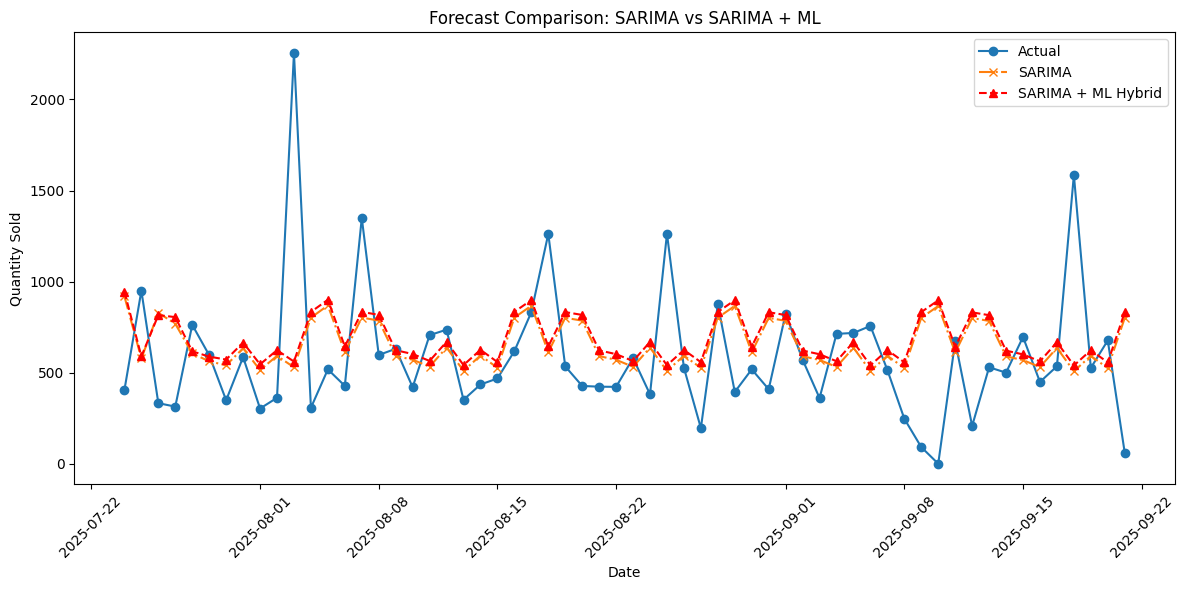

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

train_d = daily[:-60]
test_d = daily[-60:]

# ------------------------
# 2️⃣ Fit SARIMA on training data
# ------------------------
# Adjust (p,d,q) and seasonal_order=(P,D,Q,s) as per your SARIMA tuning
sarima_model = SARIMAX(train_d, order=(1,1,2), seasonal_order=(0,1,1,12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast on train and test
train_forecast = sarima_fit.predict(start=train_d.index[0], end=train_d.index[-1])
test_forecast = sarima_fit.predict(start=test_d.index[0], end=test_d.index[-1])

# ------------------------
# 3️⃣ Compute residuals on training set
# ------------------------
residuals = train_d.values - train_forecast.values

# ------------------------
# 4️⃣ Train XGBoost on sequential residuals
# ------------------------
lags = 7  # number of previous residuals to use
X_train, y_train = [], []
for i in range(lags, len(residuals)):
    X_train.append(residuals[i-lags:i])
    y_train.append(residuals[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3)
xgb.fit(X_train, y_train)

# ------------------------
# 5️⃣ Predict residuals on test set sequentially
# ------------------------
test_residual_preds = []
lags_test = list(residuals[-lags:])  # start with last lags from training

for i in range(len(test_d)):
    X_input = np.array(lags_test[-lags:]).reshape(1,-1)
    pred_resid = xgb.predict(X_input)[0]
    test_residual_preds.append(pred_resid)
    lags_test.append(pred_resid)  # roll forward

# ------------------------
# 6️⃣ Combine SARIMA + ML residuals
# ------------------------
hybrid_preds = test_forecast.values + np.array(test_residual_preds)

# ------------------------
# 7️⃣ Evaluate performance
# ------------------------
rmse = np.sqrt(mean_squared_error(test_d.values, hybrid_preds))
mae = mean_absolute_error(test_d.values, hybrid_preds)
print(f"SARIMA + ML Hybrid RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ------------------------
# 8️⃣ Plot comparison
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(test_d.index, test_d.values, label='Actual', marker='o')
plt.plot(test_d.index, test_forecast.values, label='SARIMA', linestyle='-.', marker='x')
plt.plot(test_d.index, hybrid_preds, label='SARIMA + ML Hybrid', linestyle='--', marker='^', color='red')
plt.title('Forecast Comparison: SARIMA vs SARIMA + ML')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


XGBoost RMSE: 603.6745, MAE: 417.2333


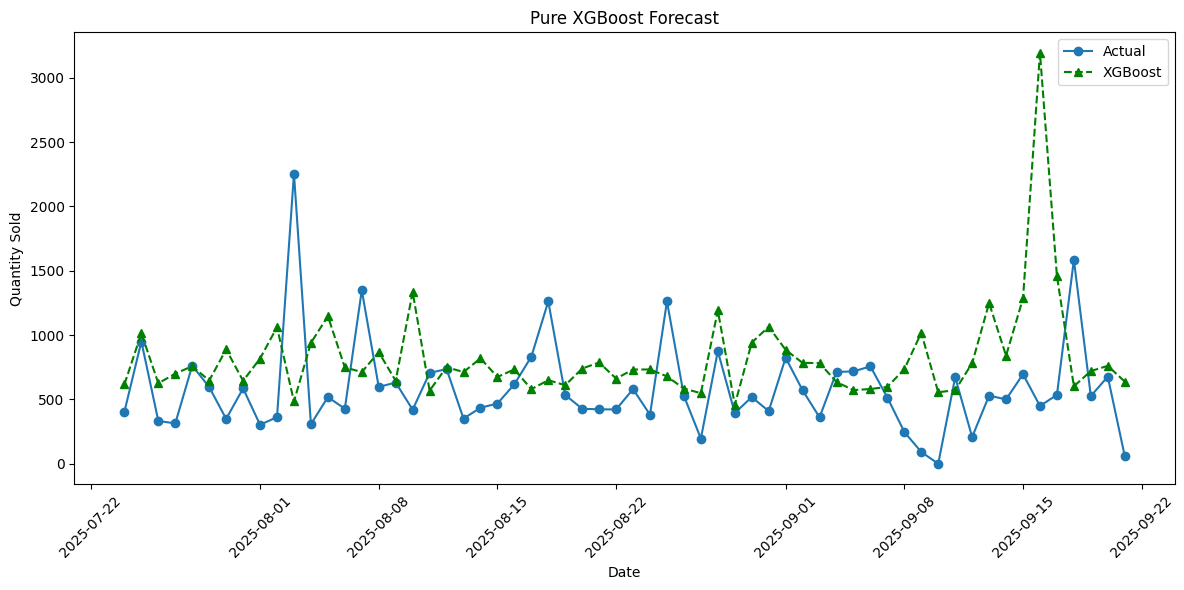

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------
# 1️⃣ Train-test split
# ------------------------
train_d = daily[:-60]
test_d = daily[-60:]

# ------------------------
# 2️⃣ Create lag features
# ------------------------
def create_lagged_features(series, lags=7):
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series[i-lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

lags = 7  # number of previous days to use
X_train, y_train = create_lagged_features(train_d.values, lags=lags)

# ------------------------
# 3️⃣ Fit XGBoost
# ------------------------
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)
xgb.fit(X_train, y_train)

# ------------------------
# 4️⃣ Forecast on test set sequentially
# ------------------------
preds = []
history = list(train_d.values)  # start with training history

for i in range(len(test_d)):
    X_input = np.array(history[-lags:]).reshape(1, -1)
    yhat = xgb.predict(X_input)[0]
    preds.append(yhat)
    history.append(test_d.values[i])  # update with actual (teacher forcing)
    # OR: history.append(yhat) for pure rolling prediction

# ------------------------
# 5️⃣ Evaluate
# ------------------------
rmse = np.sqrt(mean_squared_error(test_d.values, preds))
mae = mean_absolute_error(test_d.values, preds)
print(f"XGBoost RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ------------------------
# 6️⃣ Plot
# ------------------------
plt.figure(figsize=(12,6))
plt.plot(test_d.index, test_d.values, label='Actual', marker='o')
plt.plot(test_d.index, preds, label='XGBoost', linestyle='--', marker='^', color='green')
plt.title('Pure XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
